In [53]:

import numpy as np
import os
import re
from collections import Counter

import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# print('=3')

In [54]:
from importlib.metadata import version
import nltk
import torch
import summa
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup


nltk.download('stopwords')
from nltk.corpus import stopwords


import numpy as np
import os
import re
from collections import Counter

import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(torch.__version__)
print(pd.__version__)
print(version('summa'))

3.9.1
2.9.0
2.3.3
1.2.0


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wansookim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [56]:
data.sample(10)

,headlines,text
44558,Tesla Chief Accounting Officer quits citing pe...,Tesla's Chief Accounting Officer Eric Branderi...
8506,Google blocks gendered pronouns from AI tool t...,Google has blocked gender-based pronouns like ...
31705,New Zealand's female and male footballers to b...,New Zealand's female international football pl...
28034,July 1 to be celebrated as 'GST Day',The government will celebrate July 1 as 'GST D...
93886,Patanjali has no plans for an IPO: MD Acharya ...,Baba Ramdev-led Patanjali Ayurved has said tha...
3725,"It's a film, not tsunami: Akshaye on row over ...",Speaking about the controversy surrounding his...
15366,India calls on UN to pass global anti-terror c...,External Affairs Minister Sushma Swaraj on Sat...
35488,Driving school makes pupils put phones on park...,A driving school in the Chinese city of Dezhou...
7092,"Rahul's interview paid news, take action: BJP ...",BJP on Friday approached the Election Commissi...
88411,Record bets online over US President Trump's i...,Online wagering sites are reportedly taking re...


학습목표

1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.


2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.


3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.

평가기준

1. 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

2. 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.

3. 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.


Step 2. 데이터 전처리하기 (추상적 요약)

In [57]:
print(len(data))

98401


In [58]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [59]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [60]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [61]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [62]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

In [63]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [64]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [65]:
# 전체 Text 데이터에 대한 전처리 : 오래 걸릴수 있음
clean_text = []

for sentence in data['text']:
    clean_text.append(preprocess_sentence(sentence))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [66]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_headlines = []

for sentence in data['headlines']:
    clean_headlines.append(preprocess_sentence(sentence, remove_stopwords=False))

print("Summary 전처리 후 결과: ", clean_headlines[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [67]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [68]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

데이터로더: 훈련 & 테스트 데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


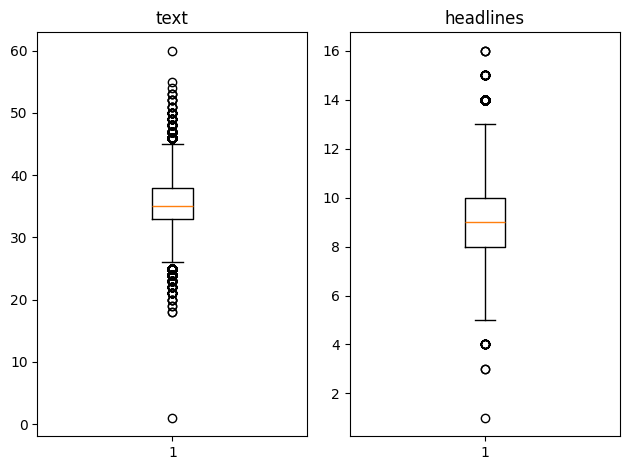

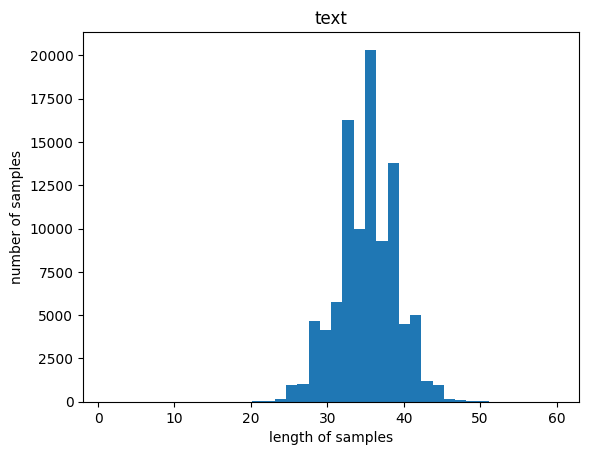

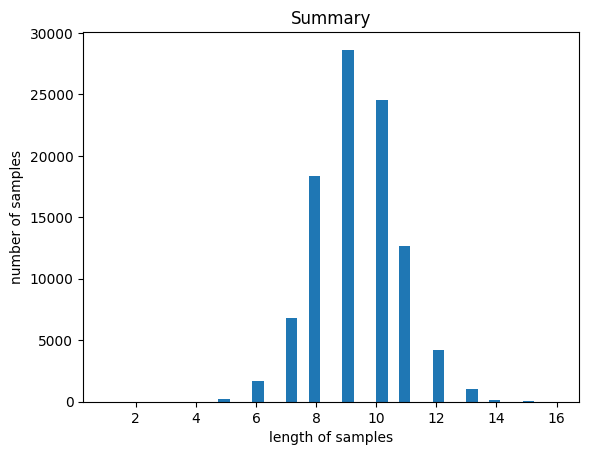

In [69]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [70]:
text_max_len = 50
headlines_max_len = 12
print('=3')

#### 성능 안좋을시 먼저 바꿔볼것

=3


In [71]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [72]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [73]:
# data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
# data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

# print('전체 샘플수 :', (len(data)))

In [74]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [75]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [76]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[34426 90962 36884 ... 79173 11931 35559]


In [77]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [78]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [79]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


정수 인코딩

In [80]:
def src_tokenizer(text): # 토크나이저 정의
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

def build_vocab(texts):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 단어 집합 생성 (빈도가 높은 순서대로)
    for word, _ in word_counter.most_common():
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

src_vocab = build_vocab(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [81]:
threshold = 7

# 전처리된 데이터 사용
text_data = data['text'].tolist()
headlines_data = data['headlines'].tolist()
# 단어 빈도수 계산
word_counter = Counter()
for text in text_data:
    word_counter.update(text.split())

total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

# 희귀 단어를 제외한 단어 사전 구축
vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) if count >= threshold}

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 76334
등장 빈도가 6번 이하인 희귀 단어의 수: 51776
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24558
단어 집합에서 희귀 단어의 비율: 67.82822857442294
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.0337692130558263


In [82]:
src_vocab_size = 25000

def build_limited_vocab(texts, vocab_size):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 빈도가 높은 상위 vocab_size - 2개 단어만 선택 (PAD, UNK 포함)
    for word, _ in word_counter.most_common(vocab_size - 2):
        vocab[word] = len(vocab)

    return vocab

src_vocab = build_limited_vocab(encoder_input_train, src_vocab_size)
print('=3')

=3


In [83]:
def text_to_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab["<UNK>"]) for word in src_tokenizer(text)]
        sequences.append(sequence)
    return sequences

# 텍스트 데이터 정수 시퀀스로 변환
encoder_input_train_seq = text_to_sequence(encoder_input_train, src_vocab)
encoder_input_test_seq = text_to_sequence(encoder_input_test, src_vocab)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train_seq[:3])
print(encoder_input_test_seq[:3])

[[423, 10, 57, 76, 133, 383, 1751, 487, 54, 5462, 147, 8675, 868, 944, 7, 6988, 148, 423, 7262, 2171, 3669, 487, 944, 67, 54, 1145, 3754, 147, 2518, 3064, 3419, 147, 734, 85, 6537], [15, 22, 1094, 14796, 12927, 88, 6108, 1358, 8, 10243, 1363, 19465, 241, 2027, 1113, 632, 2593, 3755, 5424, 19465, 19465, 5424, 10243, 1363, 23, 14797, 1113, 11, 2, 15, 12927, 950, 11, 105, 1418, 542, 1232], [1127, 34, 16699, 104, 3923, 24, 748, 939, 16699, 467, 869, 2624, 982, 2073, 339, 52, 146, 2, 3923, 869, 2624, 543, 2073, 381, 363, 230, 23, 352, 869, 2624, 3734, 381, 1768, 4514, 3923, 1141, 2073, 1914, 24, 1176, 3]]
[[232, 8, 214, 2763, 298, 145, 166, 266, 520, 87, 91, 145, 3038, 88, 166, 8, 2763, 298, 145, 637, 136, 3594, 102, 524, 166, 279, 8, 31, 588, 298, 145, 136, 8, 27], [439, 2037, 10, 58, 90, 38, 3270, 6471, 2679, 18, 4, 14, 202, 149, 225, 604, 68, 38, 276, 202, 31, 815, 358, 161, 111, 4971, 425, 1260, 3346, 493, 318, 73, 2933, 8887], [89, 668, 2130, 127, 119, 328, 43, 328, 188, 8, 3, 826, 562

In [84]:
def tar_tokenizer(text):
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

tar_vocab = build_vocab(decoder_input_train)
print('=3')

=3


In [85]:
threshold = 6

word_counter = Counter()
for text in decoder_input_train:
    word_counter.update(tar_tokenizer(text))  # 각 문장의 단어 빈도 계산

# 전체 단어 개수 및 등장 빈도 계산
total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30158
등장 빈도가 5번 이하인 희귀 단어의 수: 19783
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10375
단어 집합에서 희귀 단어의 비율: 65.5978513164003
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.668243142392272


In [86]:
tar_vocab_size = 10000
tar_vocab = build_limited_vocab(decoder_input_train + decoder_target_train, tar_vocab_size)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train_seq = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train_seq = text_to_sequence(decoder_target_train, tar_vocab)
decoder_input_test_seq = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test_seq = text_to_sequence(decoder_target_test, tar_vocab)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train_seq[:5])
print('target')
print('decoder ',decoder_target_train_seq[:5])

input
input  [[2, 67, 4410, 142, 174, 65, 3600, 9654, 8, 539], [2, 855, 58, 61, 41, 1, 1512], [2, 3033, 82, 476, 1335, 3146, 4, 804, 1893, 12, 49, 66], [2, 6625, 32, 1994, 252, 809, 243, 1425], [2, 5600, 2958, 4, 21, 1844, 15, 4, 1, 861, 945, 88]]
target
decoder  [[67, 4410, 142, 174, 65, 3600, 9654, 8, 539, 3], [855, 58, 61, 41, 1, 1512, 3], [3033, 82, 476, 1335, 3146, 4, 804, 1893, 12, 49, 66, 3], [6625, 32, 1994, 252, 809, 243, 1425, 3], [5600, 2958, 4, 21, 1844, 15, 4, 1, 861, 945, 88, 3]]


In [87]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [88]:
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [152]:
from torch.nn.utils.rnn import pad_sequence

# 텐서 변환 함수 (리스트 → PyTorch 텐서)
def convert_to_tensor(sequences):
    return [torch.tensor(seq, dtype=torch.long) for seq in sequences]

# 패딩 적용 함수 (PyTorch `pad_sequence()` 활용)
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    sequences = convert_to_tensor(sequences)  # 리스트를 텐서로 변환
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=padding_value)  # 패딩 적용
    return padded_seqs[:, :maxlen]  # maxlen 길이로 자르기 (최대 길이 초과 방지)

# 패딩 적용
encoder_input_train = pad_sequences_pytorch(encoder_input_train_seq, maxlen=text_max_len)
encoder_input_test = pad_sequences_pytorch(encoder_input_test_seq, maxlen=text_max_len)
decoder_input_train = pad_sequences_pytorch(decoder_input_train_seq, maxlen=headlines_max_len)
decoder_target_train = pad_sequences_pytorch(decoder_target_train_seq, maxlen=headlines_max_len)
decoder_input_test = pad_sequences_pytorch(decoder_input_test_seq, maxlen=headlines_max_len)
decoder_target_test = pad_sequences_pytorch(decoder_target_test_seq, maxlen=headlines_max_len)

print('=3')

=3


Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [153]:
# 인코더 LSTM 1 2 3

import torch.nn as nn
import torch.nn.functional as F

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256
src_vocab_size = len(src_vocab)  # 단어 집합 크기

# 인코더
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers,
            dropout=dropout, batch_first=True
        )

    def forward(self, x): # 인코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)  # LSTM 실행
        return output, hidden, cell

# 인코더 모델 생성
encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

In [154]:
# 디코더 설계
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout=0.4, num_layers=3):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout,
            batch_first=True
        )

    def forward(self, x, hidden, cell): # 디코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # 초기 상태를 인코더에서 전달받음
        return output, hidden, cell

# 디코더 모델 생성
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

In [155]:
# 디코더의 출력층
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, vocab_size):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.softmax_layer = nn.Linear(hidden_size, vocab_size)  # 출력층 정의

    def forward(self, encoder_input, decoder_input):
        # 인코더 실행
        encoder_output, hidden, cell = self.encoder(encoder_input)

        # 디코더 실행
        decoder_output, _, _ = self.decoder(decoder_input, hidden, cell)

        # 출력층 적용 (Softmax는 Loss 내부에서 적용되므로 생략 가능)
        output = self.softmax_layer(decoder_output)
        return output

# 모델 정의
model = Seq2Seq(encoder, decoder, tar_vocab_size)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(25000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (softmax_layer): Linear(in_features=256, out_features=10000, bias=True)
)


In [156]:
class Attention_dot(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_dot, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)  # 어텐션 가중치
        self.v = nn.Linear(hidden_size, 1, bias=False)  # 어텐션 가중치 벡터

    def forward(self, decoder_output, encoder_outputs):
        attn_weights = torch.bmm(decoder_output, encoder_outputs.transpose(1, 2))
        attn_weights = F.softmax(attn_weights, dim=-1)  # 어텐션 가중치 정규화
        attn_out = torch.bmm(attn_weights, encoder_outputs)

        return attn_out

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, hidden_size):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = Attention_dot(hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층

    def forward(self, encoder_input, decoder_input):
        encoder_outputs, hidden, cell = self.encoder(encoder_input)
        decoder_outputs, _, _ = self.decoder(decoder_input, hidden, cell)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, encoder_outputs)

        # 어텐션 결과와 디코더 출력 연결
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)

        # 어텐션 결합 후 최종 출력
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))
        output = self.output_layer(decoder_concat_output)

        return output

# 모델 생성
model = Seq2SeqWithAttention(encoder, decoder, tar_vocab_size, hidden_size)
print(model)

Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(25000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (attention): Attention_dot(
    (attn): Linear(in_features=256, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (concat): Linear(in_features=512, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10000, bias=True)
)


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Hyperparameters
batch_size = 256
epochs = 50
learning_rate = 0.001
patience = 10

# 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# PyTorch DataLoader 설정
train_dataset = TensorDataset(encoder_input_train, decoder_input_train, decoder_target_train)
test_dataset = TensorDataset(encoder_input_test, decoder_input_test, decoder_target_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: mps


In [158]:
train_losses = []
val_losses = []

# 학습 함수
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, patience):
    model.train()
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss = 0

        for encoder_input, decoder_input, target in train_loader:
            optimizer.zero_grad()

            # 정수형 변환
            encoder_input = encoder_input.to(device).long()
            decoder_input = decoder_input.to(device).long()
            target = target.to(device).long()

            # 모델 실행
            output = model(encoder_input, decoder_input)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation loss 계산
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device).long()
                decoder_input = decoder_input.to(device).long()
                target = target.to(device).long()

                output = model(encoder_input, decoder_input)
                output = output.view(-1, output.shape[-1])
                target = target.view(-1)
                loss = criterion(output, target)

                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        model.train()

In [159]:
%%time
# 대력 4분당 1 epoch => cps로 돌리고 있었음; mps로 마저 수정
# 학습 실행 콜
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs, patience=patience)

Epoch 1/50 | Train Loss: 6.8944 | Val Loss: 6.6080
Epoch 2/50 | Train Loss: 6.5439 | Val Loss: 6.3922
Epoch 3/50 | Train Loss: 6.2552 | Val Loss: 6.0598
Epoch 4/50 | Train Loss: 5.8788 | Val Loss: 5.6923
Epoch 5/50 | Train Loss: 5.4864 | Val Loss: 5.3825
Epoch 6/50 | Train Loss: 5.1844 | Val Loss: 5.1983
Epoch 7/50 | Train Loss: 4.9664 | Val Loss: 5.0730
Epoch 8/50 | Train Loss: 4.7921 | Val Loss: 4.9890
Epoch 9/50 | Train Loss: 4.6427 | Val Loss: 4.9193
Epoch 10/50 | Train Loss: 4.5162 | Val Loss: 4.8709
Epoch 11/50 | Train Loss: 4.4016 | Val Loss: 4.8270
Epoch 12/50 | Train Loss: 4.3020 | Val Loss: 4.7960
Epoch 13/50 | Train Loss: 4.2101 | Val Loss: 4.7809
Epoch 14/50 | Train Loss: 4.1251 | Val Loss: 4.7611
Epoch 15/50 | Train Loss: 4.0502 | Val Loss: 4.7584
Epoch 16/50 | Train Loss: 3.9791 | Val Loss: 4.7421
Epoch 17/50 | Train Loss: 3.9143 | Val Loss: 4.7355
Epoch 18/50 | Train Loss: 3.8553 | Val Loss: 4.7354
Epoch 19/50 | Train Loss: 3.7999 | Val Loss: 4.7351
Epoch 20/50 | Train L

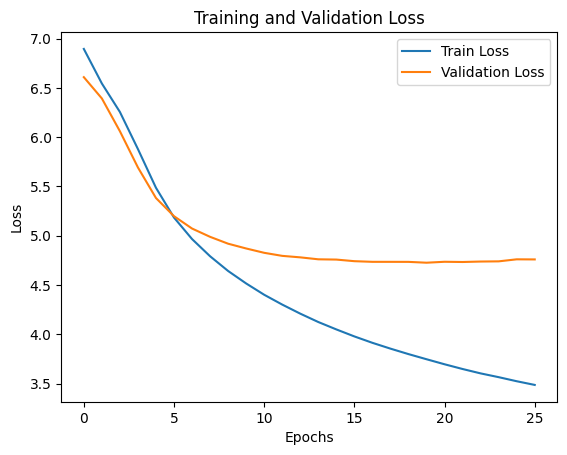

In [160]:
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [161]:
#Inference 모델 구현 후 실제 결과와 요약문 비교하기

src_index_to_word = {idx: word for word, idx in src_vocab.items()} # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_vocab # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()} # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [162]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
decoder.to(device)

# 인코더 설계
def encode_input(encoder, input_seq):
    encoder_outputs, hidden, cell = encoder(input_seq)
    return encoder_outputs, hidden, cell

# 이전 시점의 상태들을 저장하는 텐서
num_layers = 3  # 디코더 LSTM 레이어 개수 (설정에 맞춰 조정)
batch_size = 1

decoder_state_input_h = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_state_input_c = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_input = torch.zeros((batch_size, 1), dtype=torch.long, device=device)

dec_emb2 = decoder.embedding(decoder_input)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder(decoder_input, decoder_state_input_h, decoder_state_input_c)

print('=3')

=3


In [163]:
class DecoderWithAttention(nn.Module):
    def __init__(self, decoder, attention, hidden_size, vocab_size):
        super(DecoderWithAttention, self).__init__()
        self.decoder = decoder  # 기존 디코더
        self.attention = attention  # 어텐션 레이어
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합 레이어
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층
        self.softmax = nn.Softmax(dim=-1)  # 소프트맥스

    def forward(self, decoder_inputs, decoder_hidden_state, decoder_state_h, decoder_state_c):
        # 디코더 실행
        decoder_outputs, state_h, state_c = self.decoder(decoder_inputs, decoder_state_h, decoder_state_c)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, decoder_hidden_state)

        # 어텐션과 디코더 출력 결합
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))

        # 최종 출력층 적용
        decoder_outputs2 = self.softmax(self.output_layer(decoder_concat_output))

        return decoder_outputs2, state_h, state_c

# 기존 Attention 클래스 사용
attention_layer = Attention_dot(hidden_size)

# 디코더 모델 생성
decoder_model = DecoderWithAttention(decoder, attention_layer, hidden_size, tar_vocab_size)
print('=3')

=3


In [164]:
# def decode_sequence(input_seq, encoder, decoder, tar_word_to_index, tar_index_to_word, text_max_len, summary_max_len, device):
#     # 입력을 PyTorch Tensor로 변환
#     input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)

#     # 인코더 실행하여 초기 상태(hidden, cell) 얻기
#     with torch.no_grad():
#         e_out, e_h, e_c = encoder(input_seq)

#     e_out = e_out.repeat(1, text_max_len, 1)  # 차원 조정 (np.tile 대신 repeat 사용)

#     # <SOS>에 해당하는 토큰 생성
#     target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
#     target_seq[0, 0] = tar_word_to_index['sostoken']

#     stop_condition = False
#     decoded_sentence = ''

#     while not stop_condition:
#         # 디코더 실행
#         with torch.no_grad():
#             output_tokens, h, c = decoder(target_seq, e_h, e_c)

#         # 가장 높은 확률을 가진 단어 선택
#         sampled_token_index = torch.argmax(output_tokens[0, -1, :]).item()
#         sampled_token = tar_index_to_word[sampled_token_index]

#         if sampled_token != 'eostoken':
#             decoded_sentence += ' ' + sampled_token

#         # 종료 조건: <eos>에 도달하거나 최대 길이를 초과하면 중단
#         if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len - 1):
#             stop_condition = True

#         # 길이가 1인 타겟 시퀀스를 업데이트
#         target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
#         target_seq[0, 0] = sampled_token_index

#         # 상태 업데이트
#         e_h, e_c = h, c

#     return decoded_sentence
# print("=3")

In [165]:
def decode_sequence(input_seq, model, tar_word_to_index, tar_index_to_word, summary_max_len, device):
    
    # Ensure model is on the correct device and in evaluation mode
    model.to(device)
    model.eval()

    # 1. Prepare Input and Encoder
    # Convert input_seq to tensor (it's already a 1D tensor from cell 112, just add batch dim)
    # The input_seq from cell 112 is like [tensor(1), tensor(2), ...]
    # We need to stack it and add a batch dimension
    if not torch.is_tensor(input_seq):
         input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)
    
    # Add batch dimension if it's not there
    if input_seq.dim() == 1:
        input_seq = input_seq.unsqueeze(0)
        
    input_seq = input_seq.to(device)

    with torch.no_grad():
        # Pass input through encoder
        encoder_outputs, hidden, cell = model.encoder(input_seq)

    # 2. Prepare Decoder
    # Start with the 'sostoken'
    decoder_input = torch.tensor([[tar_word_to_index['sostoken']]], dtype=torch.long, device=device)

    decoded_sentence = ''
    
    # 3. Decoding Loop
    for _ in range(summary_max_len):
        with torch.no_grad():
            # Pass the *single* previous token and the encoder states to the decoder LSTM
            # decoder_outputs shape: [1, 1, hidden_size]
            decoder_outputs, hidden, cell = model.decoder(decoder_input, hidden, cell)

            # --- This is the missing part ---
            
            # 4. Apply Attention
            # attn_out shape: [1, 1, hidden_size]
            attn_out = model.attention(decoder_outputs, encoder_outputs)

            # 5. Concatenate and Pass through Final Layers
            # decoder_concat_output shape: [1, 1, hidden_size * 2]
            decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)
            
            # decoder_concat_output shape: [1, 1, hidden_size]
            decoder_concat_output = torch.tanh(model.concat(decoder_concat_output))
            
            # output shape: [1, 1, tar_vocab_size]
            output = model.output_layer(decoder_concat_output)
            # --- End of missing part ---

            # Get the token with the highest probability
            # We apply softmax here just for prediction (optional, as argmax is the same)
            # output = F.softmax(output, dim=-1) # Not needed for argmax
            
            # sampled_token_index shape: [1]
            sampled_token_index = torch.argmax(output[0, -1, :]).item()
            sampled_token = tar_index_to_word.get(sampled_token_index, "<UNK>")

            if sampled_token == 'eostoken':
                break
            
            if sampled_token != "<UNK>": # Optional: avoid adding UNK
                decoded_sentence += ' ' + sampled_token

            # The predicted token becomes the next input
            decoder_input = torch.tensor([[sampled_token_index]], dtype=torch.long, device=device)

    return decoded_sentence.strip()

print("=3")

=3


In [166]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0:  # 패딩(0) 제외
            temp = temp + src_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0 and key != tar_word_to_index['sostoken'] and key != tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()  # 양쪽 공백 제거

print('=3')

=3


In [185]:
%%time
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    
    # Get the raw input sequence (as a tensor)
    input_seq = encoder_input_test[i] 
    
    # Pass the full 'model', not 'encoder' and 'decoder'
    print("예측 요약 :", decode_sequence(input_seq, model, tar_word_to_index, tar_index_to_word, headlines_max_len, device))
    print("\n")

원문 : google thursday said launch demand audio news feed feature managed ai program google assistant feature activated saying hey google play news google said video feature part google news initiative initially launch us users english google added
실제 요약 : google unveils ai driven audio news feature on its assistant
예측 요약 : google to remove users to remove to users


원문 : million tweets chadwick boseman starrer superhero film black panther become tweeted film time twitter announced tuesday broke record film star wars force awakens film star wars last jedi holds third place among tweeted films time
실제 요약 : black panther becomes most tweeted about film of all time
예측 요약 : black panther features on of the world film


원문 : public works department delhi government reportedly slapped fine lakh aap unauthorised occupation <UNK> avenue party office delhi government allotted bungalow aap party approved land allotment policy state parties however pwd directed aap vacate office april
실제 요약 : aap f

Step 5. Summa을 이용해서 추출적 요약해보기

In [179]:
# import requests
# from summa.summarizer import summarize
# print(data['headlines'])
# print(summarize(drop_train, ratio=0.01))


original_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

original_data.drop_duplicates(subset = ['text'], inplace=True)
original_data.reset_index(drop=True, inplace=True)
test_indices = indices[-n_of_val:]


In [181]:
%%time
from summa.summarizer import summarize

print("--- Comparing Abstractive vs. Extractive Summaries ---")

# Loop 50-100 (just like your cell 167)
for i in range(50, 100):
    
    # --- Get Original Raw Text ---
    # Get the original index from your shuffled test set
    original_index = test_indices[i]
    
    # Get the RAW text and headline from the 'original_data' we just reloaded
    raw_text = original_data.loc[original_index]['text']
    raw_headline = original_data.loc[original_index]['headlines']
    
    # --- 1. Get Your Abstractive Prediction ---
    # (This uses your existing trained model and functions)
    input_seq = encoder_input_test[i] 
    abstractive_prediction = decode_sequence(input_seq, model, tar_word_to_index, tar_index_to_word, headlines_max_len, device)
    
    # --- 2. Get Summa's Extractive Prediction ---
    # We pass the 'raw_text'. Your ratio=0.01 was too small.
    # Let's ask for 15 words instead.
    extractive_prediction = summarize(raw_text, words=15)
    
    # --- 3. Print Comparison ---
    print(f"--- SAMPLE {i} ---")
    print(f"실제요약:\n{raw_headline}\n")
    print(f"추상적요약:\n{abstractive_prediction}\n")
    print(f"추출적요약:\n{extractive_prediction}")
    print("="*30 + "\n")

--- Comparing Abstractive vs. Extractive Summaries ---
--- SAMPLE 50 ---
실제요약:
Google unveils AI-driven audio news feature on its Assistant

추상적요약:
google to remove users to remove to users

추출적요약:
Google on Thursday said it will launch an on-demand audio news feed feature which will be managed by its AI program Google Assistant.

--- SAMPLE 51 ---
실제요약:
Black Panther becomes most tweeted-about film of all time

추상적요약:
black panther features on of the world film

추출적요약:
The 2017 film 'Star Wars: The Last Jedi' holds the third place among the most-tweeted films of all time.

--- SAMPLE 52 ---
실제요약:
AAP fined Ã¢ÂÂ¹27L for 'unauthorised occupation' of Delhi office

추상적요약:
delhi govt to pay jail for scheme

추출적요약:
The Public Works Department of Delhi government has reportedly slapped a fine of Ã¢ÂÂ¹27 lakh on AAP for the "unauthorised occupation" of its Rouse Avenue party office.

--- SAMPLE 53 ---
실제요약:
Carrie Fisher to feature in last Star Wars film: Reports

추상적요약:
released

추출적요약:
Ca

3. 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.
Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.



In [184]:
import pandas as pd
from summa.summarizer import summarize
import torch
import re # Needed for simple keyword check

# --- Ensure these variables are defined from your notebook ---
# original_data (loaded and index reset)
# test_indices
# model
# decode_sequence
# tar_word_to_index
# tar_index_to_word
# headlines_max_len
# device
# encoder_input_test
# src_index_to_word # For seq2text (if needed, though not directly used in table)
# seq2text, seq2summary # If needed for reference (not directly used in table)
# -----------------------------------------------------------

results = [] # To store dictionaries for each sample

print("Generating summaries for comparison...")

# Loop through the desired samples (50 to 99)
for i in range(50, 100):
    sample_data = {}
    sample_data['Sample'] = i

    # --- Get Original Raw Text and Headline ---
    try:
        original_index = test_indices[i]
        raw_text = original_data.loc[original_index]['text']
        raw_headline = original_data.loc[original_index]['headlines']
        sample_data['Actual Headline'] = raw_headline
    except Exception as e:
        print(f"Error getting original data for index {i} (original index: {original_index}): {e}")
        sample_data['Actual Headline'] = "Error"
        raw_text = "" # Set raw_text to empty to avoid error in summarize

    # --- Get Abstractive Prediction ---
    try:
        input_seq = encoder_input_test[i]
        abstractive_prediction = decode_sequence(input_seq, model, tar_word_to_index, tar_index_to_word, headlines_max_len, device)
        sample_data['Abstractive'] = abstractive_prediction
    except Exception as e:
        print(f"Error generating abstractive summary for sample {i}: {e}")
        sample_data['Abstractive'] = "Error"

    # --- Get Extractive Prediction ---
    try:
        # Using words=15 as before, adjust if needed
        extractive_prediction = summarize(raw_text, words=15)
        # Handle cases where summarize returns None or empty string
        if not extractive_prediction:
             extractive_prediction = "(Empty)"
        sample_data['Extractive'] = extractive_prediction
    except Exception as e:
        # Catch potential errors from summa (e.g., text too short)
        print(f"Error generating extractive summary for sample {i}: {e}")
        sample_data['Extractive'] = "Error/Empty"

    results.append(sample_data)

print("Summaries generated. Now analyzing...")

# --- Analysis Function (Simple Heuristics) ---
def analyze_summary(actual, abstractive, extractive):
    analysis = {}

    # Simple function to get keywords (lowercase nouns/verbs - very basic)
    def get_keywords(text):
         # Remove punctuation, lowercase, split, filter short words
         words = re.sub(r"[^a-zA-Z\s]", "", text).lower().split()
         # You might add POS tagging here for better keyword extraction
         keywords = {word for word in words if len(word) > 3}
         return keywords

    actual_keywords = get_keywords(actual)

    # Analyze Abstractive
    abs_grammar = "Okay"
    if len(abstractive.split()) < 3 or abstractive == "Error":
        abs_grammar = "No"
    elif abstractive.split()[0] == abstractive.split()[-1] and len(abstractive.split()) > 1: # Check repetition
         abs_grammar = "Poor (Rep.)"

    abs_keywords_present = get_keywords(abstractive)
    abs_overlap = actual_keywords.intersection(abs_keywords_present)
    abs_keyword_score = "No"
    if len(abs_overlap) >= 2:
         abs_keyword_score = "Yes"
    elif len(abs_overlap) == 1:
         abs_keyword_score = "Partial"

    analysis['Abs_Grammar'] = abs_grammar
    analysis['Abs_Keywords'] = abs_keyword_score

    # Analyze Extractive
    ext_grammar = "Yes"
    if extractive == "(Empty)" or extractive == "Error/Empty":
        ext_grammar = "N/A"

    ext_keywords_present = get_keywords(extractive)
    ext_overlap = actual_keywords.intersection(ext_keywords_present)
    ext_keyword_score = "No"
    if extractive == "(Empty)" or extractive == "Error/Empty":
         ext_keyword_score = "N/A"
    elif len(ext_overlap) >= 2:
         ext_keyword_score = "Yes"
    elif len(ext_overlap) >= 1 : # Lower threshold for extractive as it might grab related context
        ext_keyword_score = "Partial"


    analysis['Ext_Grammar'] = ext_grammar
    analysis['Ext_Keywords'] = ext_keyword_score

    # Simple Winner Determination
    winner = "Neither"
    abs_score = (abs_grammar != "No") + (abs_keyword_score == "Yes") * 2 + (abs_keyword_score == "Partial")
    ext_score = (ext_grammar == "Yes") + (ext_keyword_score == "Yes") * 2 + (ext_keyword_score == "Partial")

    if ext_score > abs_score and ext_grammar != "N/A":
        winner = "Extractive"
    elif abs_score > ext_score and abs_grammar != "No":
        winner = "Abstractive"
    elif ext_score == abs_score and ext_score > 0 :
         winner = "Tie (Extractive Pref)" # Prefer extractive if scores are equal but > 0


    analysis['Comparison'] = f"**Winner:** {winner}"


    return analysis


# --- Apply Analysis and Create DataFrame ---
analysis_results = []
for res in results:
    analysis = analyze_summary(res['Actual Headline'], res['Abstractive'], res['Extractive'])
    # Combine original results with analysis
    combined = {**res, **analysis}
    analysis_results.append(combined)

# Create DataFrame
df_comparison = pd.DataFrame(analysis_results)

# Reorder columns for better readability
df_comparison = df_comparison[[
    'Sample', 'Actual Headline',
    'Abstractive',
    'Extractive',

]]

# Display the DataFrame
# Optional: Set display options for wider columns if needed
# pd.set_option('display.max_colwidth', None)
print("\n--- Comparison Table ---")
display(df_comparison) # Use display() in notebooks for better formatting

Generating summaries for comparison...
Summaries generated. Now analyzing...

--- Comparison Table ---


,Sample,Actual Headline,Abstractive,Extractive
0,50,Google unveils AI-driven audio news feature on...,google to remove users to remove to users,Google on Thursday said it will launch an on-d...
1,51,Black Panther becomes most tweeted-about film ...,black panther features on of the world film,The 2017 film 'Star Wars: The Last Jedi' holds...
2,52,AAP fined Ã¢ÂÂ¹27L for 'unauthorised occupati...,delhi govt to pay jail for scheme,The Public Works Department of Delhi governmen...
3,53,Carrie Fisher to feature in last Star Wars fil...,released,Carrie's brother Todd Fisher said the family h...
4,54,Grocery startup ZopNow scales down operations ...,startup startup,A former employee at ZopNow said that the star...
5,55,Huawei worker arrested in Poland over alleged ...,arrested for spying on security attack,Poland has arrested a Huawei employee and a fo...
6,56,Video of late celeb chef Anthony with Mammoott...,actor passes away at,A video of celebrity chef Anthony Bourdain wit...
7,57,Bomb that killed 40 children in Yemen was US m...,indonesian forces killed in of isis in mosul,(Empty)
8,58,Trump's UN address unacceptable and meddling: ...,russia slams trump for of us presidential polls,Cuba on Tuesday denounced US President Donald ...
9,59,My fight is for all the soldiers: Tej Bahadur,of are tej bahadur cm,"Following his dismissal, former BSF jawan Tej ..."
